# Qiskit config

In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.test.mock import FakeMontreal, FakeMumbai
from qiskit.providers.aer.backends import AerSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'

backend_0  = Aer.get_backend('qasm_simulator') 
backend_1  = provider.get_backend('ibmq_qasm_simulator')
backend_2  = provider.get_backend('ibmq_santiago')
backend_3  = provider.get_backend('ibmq_manila')
backend_4  = provider.get_backend('ibmq_casablanca')
backend_5  = provider.get_backend('ibmq_jakarta')
backend_6  = FakeMontreal()
backend_7  = FakeMumbai()

shots      = 8192

"""
    Select the backends that will be compared.
"""
backends = [ backend_0, backend_7 ]


# Experiment procedures

In [7]:
import numpy as np
import sys
sys.path.append('../../')
from qclib.state_preparation.schmidt import initialize

def measurement(circuit, c):
    n = len(c)
    circuit.measure(list(range(n)), c)

    job = execute(circuit, backend, shots=shots) # , optimization_level=3)
    
    counts = job.result().get_counts(circuit)
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**n):
        pattern = '{:0{}b}'.format(m, n)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0
            
    return { key : value/v for (key, value) in counts2.items() }
    
def run_circuit(state, r=0):
    circuit = initialize(state, r)

    n = int(np.log2(len(input_state)))
    c = ClassicalRegister(n)
    circuit.barrier()
    circuit.add_register(c)

    prob = measurement(circuit, c)
    
    return np.array([val for key, val in prob.items()])

def get_state_vector(circuit):
    backend = AerSimulator()
    tcircuit = transpile(circuit, backend)
    tcircuit.save_statevector()
    state_vector = backend.run(tcircuit).result().get_statevector()

    return state_vector

def plot(r, mae):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Data
    df=pd.DataFrame({ 'x_values': r, 'mae': mae })

    # multiple line plots
    plt.plot( 'x_values', 'mae' , data=df, marker='o', markersize=8)
    plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend()
    
    # config
    #plt.legend(fontsize=12)
    #plt.xticks(r, fontsize=14)
    #plt.xlabel('s', fontsize=16)
    #plt.gcf().set_dpi(200)
    
    # show graph
    plt.show()

def plot_result(n, result):
    r_range = [r[0] for r in result[n]]
    mae     = [r[1] for r in result[n]]
    l2n     = [r[2] for r in result[n]]
    
    #plot(r_range, mae)
    plot(r_range, l2n)

# State Vector Experiment

In [3]:
reps = 40
min_n = 3
max_n = 8

rnd = np.random.RandomState(42)

result2 = {}
for n in range(min_n, max_n+1):
    print('\nn = {0}'.format(n))

    result2[n] = []

    for r in [2**m for m in range(n//2+1)][::-1]: # iso:{1<=rank<2**(n_qubits//2)};uni:{rank=2**(n_qubits//2)}
        probs2 = []
        ideals2 = []
        for i in range(reps):
            input_state = rnd.rand(2**n) + rnd.rand(2**n) * 1j
            input_state = input_state/np.linalg.norm(input_state)

            circuit = initialize(input_state, low_rank = r)
            probs2.append(get_state_vector(circuit))
            ideals2.append( input_state ) 

        diff = np.mean( np.array(probs2) - np.array(ideals2), axis=0 )
        mae = np.sum(np.abs( diff )) # / (2**n)
        l2n = np.linalg.norm( diff ) # l2 norm (euclidian distance)
        
        result2[n].append([r, mae, l2n])

        print('\trank = {0}\tMAE = {1:.6f}\tMAE norm = {2:.6f}\tL2 norm = {3:.6f}'.format(r, mae, mae/(2**n), l2n))


n = 3
	rank = 2	MAE = 0.000000	MAE norm = 0.000000	L2 norm = 0.000000
	rank = 1	MAE = 0.179036	MAE norm = 0.022379	L2 norm = 0.073323

n = 4
	rank = 4	MAE = 0.000000	MAE norm = 0.000000	L2 norm = 0.000000
	rank = 2	MAE = 0.124984	MAE norm = 0.007812	L2 norm = 0.033363
	rank = 1	MAE = 0.323952	MAE norm = 0.020247	L2 norm = 0.088837

n = 5
	rank = 4	MAE = 0.000000	MAE norm = 0.000000	L2 norm = 0.000000
	rank = 2	MAE = 0.265190	MAE norm = 0.008287	L2 norm = 0.051697
	rank = 1	MAE = 0.570688	MAE norm = 0.017834	L2 norm = 0.108396

n = 6
	rank = 8	MAE = 0.000000	MAE norm = 0.000000	L2 norm = 0.000000
	rank = 4	MAE = 0.225950	MAE norm = 0.003530	L2 norm = 0.031620
	rank = 2	MAE = 0.554347	MAE norm = 0.008662	L2 norm = 0.077061
	rank = 1	MAE = 0.864356	MAE norm = 0.013506	L2 norm = 0.116585

n = 7
	rank = 8	MAE = 0.000000	MAE norm = 0.000000	L2 norm = 0.000000
	rank = 4	MAE = 0.481102	MAE norm = 0.003759	L2 norm = 0.047034
	rank = 2	MAE = 0.921574	MAE norm = 0.007200	L2 norm = 0.090624
	rank

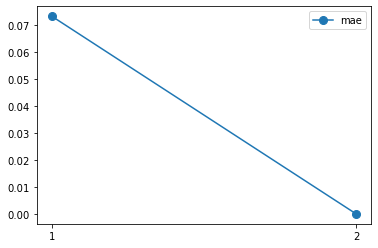

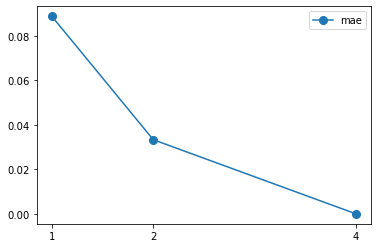

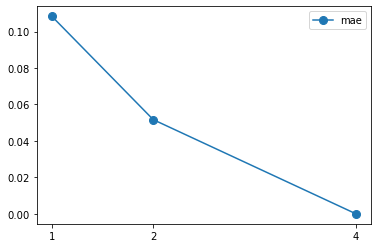

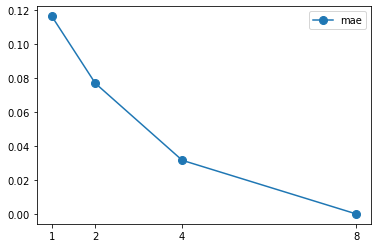

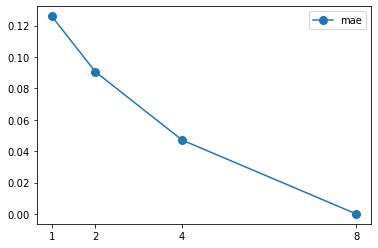

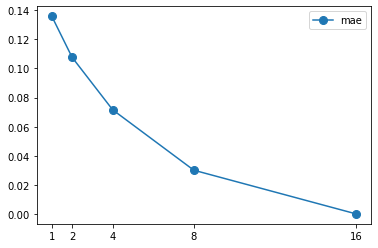

In [8]:
for n in range(min_n, max_n+1):
    plot_result(n, result2)

# Measurement Experiment

In [3]:
reps = 10
min_n = 3
max_n = 8

rnd = np.random.RandomState(42)

result = {}
for j, backend in enumerate(backends):
    backend_name = backend.name()
    backend_config = backend.configuration()
    backend_qubits = backend_config.n_qubits
    
    print('\nExperiments using {0} backend, with {1} qubits available.'.format(backend_name, backend_qubits))

    result[backend_name] = {}
    for n in range(min_n, max_n+1):
        print('\nn = {0}'.format(n))

        result[backend_name][n] = []

        for r in [2**m for m in range(n//2+1)][::-1]: # iso:{1<=rank<2**(n_qubits//2)};uni:{rank=2**(n_qubits//2)}
            probs = []
            probs2 = []
            ideals = []
            for i in range(reps):
                input_state = ( ((1.0 - 0.001) * rnd.rand(2**n) + 0.001) + 
                                ((1.0 - 0.001) * rnd.rand(2**n) + 0.001) * 1j )
                input_state = input_state/np.linalg.norm(input_state)
        
                probs.append( run_circuit(input_state, r) )
                ideals.append( np.power(np.abs(input_state), 2) ) 
            
                circuit = initialize(input_state, low_rank = r)
                probs2.append(get_state_vector_prob(circuit))
        
            
            mae = np.sum(np.abs( np.mean( np.array(probs) - np.array(ideals), axis=0 ) )) / (2**n)
                        
            result[backend_name][n].append([r, mae])
            
            print('\trank = {0}\tMAE = {1}\tMAE_r{0}/MAE_r{2} = {3}'.format(r,
                                                                            mae,
                                                                            result[backend_name][n][0][0],
                                                                            mae/result[backend_name][n][0][1]))

        


Experiments using qasm_simulator backend, with 29 qubits available.

n = 3
	rank = 2	MAE = 0.0006050026813318671	MAE_r2/MAE_r2 = 1.0
	rank = 1	MAE = 0.009233215152224944	MAE_r1/MAE_r2 = 15.261445010291073

n = 4
	rank = 4	MAE = 0.0004960537779635662	MAE_r4/MAE_r4 = 1.0
	rank = 2	MAE = 0.006052443512404848	MAE_r2/MAE_r4 = 12.201184188641305
	rank = 1	MAE = 0.00646849776237626	MAE_r1/MAE_r4 = 13.039912303321586

n = 5
	rank = 4	MAE = 0.00047169946886383297	MAE_r4/MAE_r4 = 1.0
	rank = 2	MAE = 0.002760047044689531	MAE_r2/MAE_r4 = 5.851282918205453
	rank = 1	MAE = 0.003393241038373725	MAE_r1/MAE_r4 = 7.193650326863656

n = 6
	rank = 8	MAE = 0.00036987661972326066	MAE_r8/MAE_r8 = 1.0
	rank = 4	MAE = 0.001237142176168127	MAE_r4/MAE_r8 = 3.3447428417988383
	rank = 2	MAE = 0.0016879100009151802	MAE_r2/MAE_r8 = 4.563440647257087
	rank = 1	MAE = 0.0023946259683668364	MAE_r1/MAE_r8 = 6.474120938377993

n = 7
	rank = 8	MAE = 0.0002126282097011923	MAE_r8/MAE_r8 = 1.0
	rank = 4	MAE = 0.0007113024042

/home/israel/anaconda3/lib/python3.7/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/home/israel/anaconda3/lib/python3.7/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['id', 'rz', 'sx', 'x', 'cx', 'reset']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


	rank = 8	MAE = 0.0013126916836211473	MAE_r8/MAE_r8 = 1.0
	rank = 4	MAE = 0.0013254644819651617	MAE_r4/MAE_r8 = 1.0097302348322799
	rank = 2	MAE = 0.0013473258334657616	MAE_r2/MAE_r8 = 1.0263840704384397
	rank = 1	MAE = 0.001073106972686622	MAE_r1/MAE_r8 = 0.8174859230664014

n = 8
	rank = 16	MAE = 0.0006987097075512518	MAE_r16/MAE_r16 = 1.0
	rank = 8	MAE = 0.0007144450571983348	MAE_r8/MAE_r16 = 1.0225205825495545
	rank = 4	MAE = 0.0007632857567056282	MAE_r4/MAE_r16 = 1.0924218576849236
	rank = 2	MAE = 0.0007351655483060365	MAE_r2/MAE_r16 = 1.0521759471219463
	rank = 1	MAE = 0.000651747777817585	MAE_r1/MAE_r16 = 0.9327876380904269



 qasm_simulator 



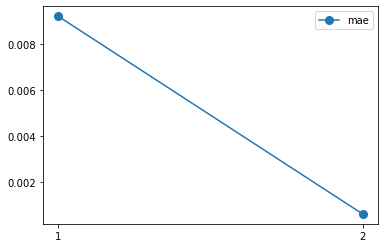

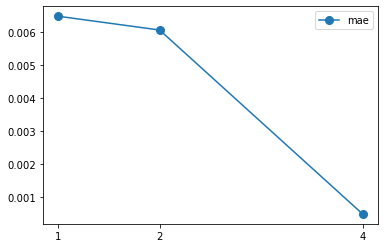

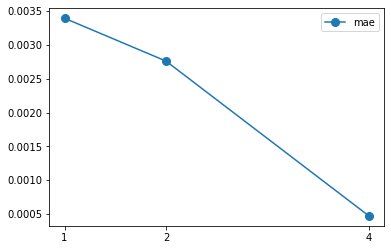

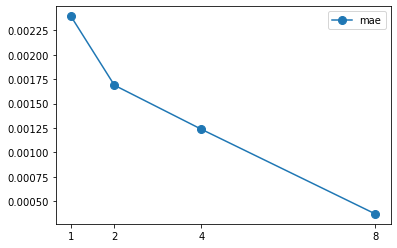

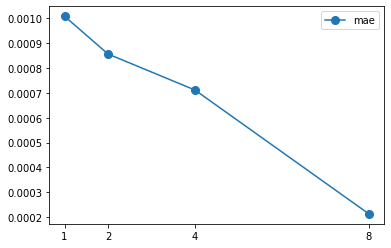

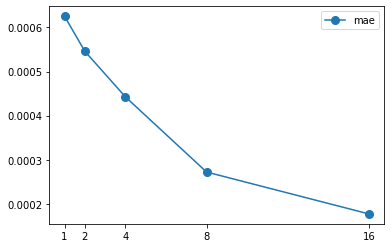


 fake_mumbai 



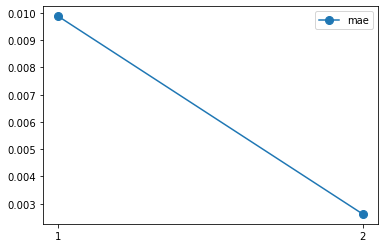

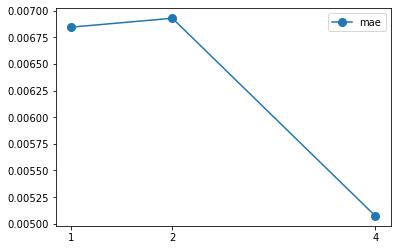

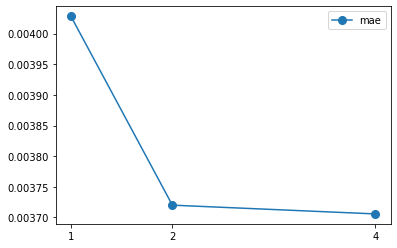

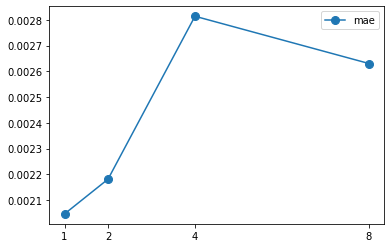

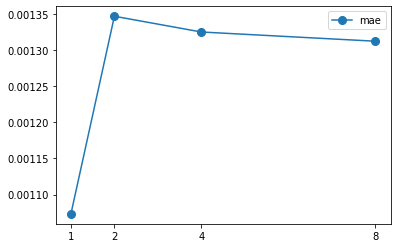

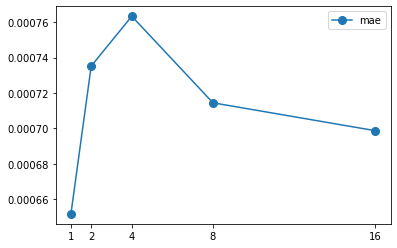

In [4]:
for j, backend in enumerate(backends):
    backend_name = backend.name()
    print('\n',backend_name,'\n')
    for n in range(min_n, max_n+1):
        plot_result(n, result[backend_name])